#**Main Code Section**

This project will evaluate the outcomes of a given NBA match between two teams. This will be done through the training of a machine learning model on historical game data. The model will evaluate the outcome by inputting current NBA team data, obtained through the official NBA Stats API.

If you'd like to test out the model yourself, please go to runtime, press run all, and then scroll down to the interactive section at the bottom of the notebook.

First, we will install any neccessary libraries. If Colab prompts a restart, press yes.

In [ ]:
pip install nba_api

In [ ]:
pip install ipywidgets

Then, import necessary libraries.

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

We will import in the necessary .csv files from Github. These .csv files have been obtained from Kaggle, from Nathan Lauga. The numbers used to generate these .csv files have also been obtained from the official NBA Stats API. The link to the kaggle page is here: https://www.kaggle.com/datasets/nathanlauga/nba-games

In [ ]:
gameurl = 'https://raw.githubusercontent.com/bchan98/CapstoneProject/main/games.csv'
gamefile = pd.read_csv(gameurl)

Now, we will start processing and cleaning of dataset. First, we will check that the data has been made into a pandas dataframe.

In [ ]:
gamefile.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,...,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,...,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,...,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,...,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


Then, we will split data into training and testing datasets.

In [ ]:
training_data = gamefile[gamefile['SEASON'] == 2021]
testing_data = gamefile[gamefile['SEASON'] == 2022]

homeWins = training_data['HOME_TEAM_WINS'].value_counts()
totalGames = training_data.shape[0]
count_ones = homeWins.get(1,0)

print(count_ones)
print(totalGames)

hw2 = testing_data['HOME_TEAM_WINS'].value_counts()
tG = testing_data.shape[0]
c1 = hw2.get(1,0)

print(c1)
print(tG)

768
1389
319
542


As a rudimentary check, we will determine if there any duplicate games existing in our unmodified training data.

In [ ]:
dupeCount = training_data['GAME_ID'].value_counts()
hasDupe = any(count > 1 for count in dupeCount)

if hasDupe:
  print("There are duplicate games.")
else:
  print("There are no duplicate games.")

There are no duplicate games.


First, we will implement rolling averages for score by team - To do so, we will generate a method to create a rolling average.

In [ ]:
def rolling_average(group, cols, new_cols):
  group = group.sort_values("GAME_DATE_EST")
  rolling_stats = group[cols].rolling(5, closed='left').mean()
  group[new_cols] = rolling_stats
  group = group.dropna(subset=new_cols)
  return group

We will generate the columns for rolling data, then calculate the rolling average for each column.

In [ ]:
cols = ["PTS_home", "FG_PCT_home", "REB_home", "FG3_PCT_home", "PTS_away", "FG_PCT_away", "REB_away", "FG3_PCT_away"]
new_cols = [f"{c}_rolling" for c in cols]
new_cols

['PTS_home_rolling',
 'FG_PCT_home_rolling',
 'REB_home_rolling',
 'FG3_PCT_home_rolling',
 'PTS_away_rolling',
 'FG_PCT_away_rolling',
 'REB_away_rolling',
 'FG3_PCT_away_rolling']

In [ ]:
training_data_rolling = training_data.groupby("HOME_TEAM_ID").apply(lambda x: rolling_average(x, cols, new_cols))
testing_data_rolling = testing_data.groupby("HOME_TEAM_ID").apply(lambda x: rolling_average(x, cols, new_cols))

training_data_rolling = training_data_rolling.droplevel("HOME_TEAM_ID")
testing_data_rolling = testing_data_rolling.droplevel("HOME_TEAM_ID")

To verify our modified dataset is still looking good, let's check it.

In [ ]:
homeWins = training_data_rolling['HOME_TEAM_WINS'].value_counts()
dupeCount = training_data['GAME_ID'].value_counts()
hasDupe = any(count > 1 for count in dupeCount)

if hasDupe:
  print("There are duplicate games.")
else:
  print("There are no duplicate games.")

totalGames = training_data_rolling.shape[0]
count_ones = homeWins.get(1,0)

print(count_ones)
print(totalGames)


There are no duplicate games.
684
1239


Then, we can train the machine model on the rolling averages. To do so, we will be using a Random Forest Classifier. This is a good model as it takes in multiple decision trees to decide a prediction for a final result. Here is a diagram showing how it works:

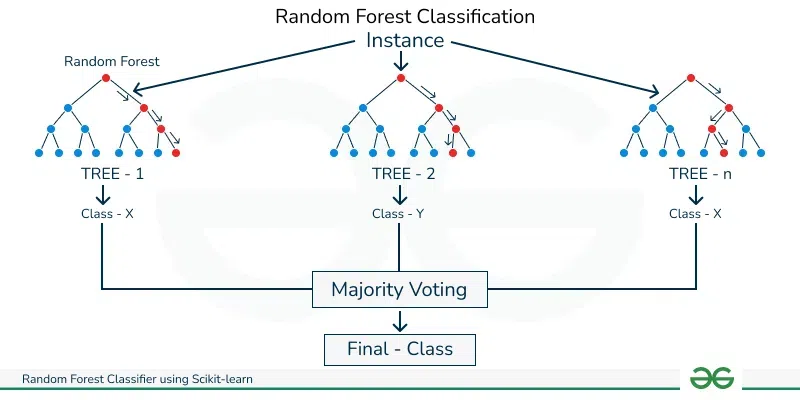

For our classifier, we will use 50 estimators and 10 samples split. Additionally, we will ensure our random_state parameter = 1, to ensure we get the same result as long as we feed in the same data.

In [ ]:
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)
predictors = ["HOME_TEAM_ID", "TEAM_ID_away", "PTS_home_rolling", "FG_PCT_home_rolling", "REB_home_rolling", "FG3_PCT_home_rolling", "PTS_away_rolling", "FG_PCT_away_rolling", "REB_away_rolling", "FG3_PCT_away_rolling"]
rf.fit(training_data_rolling[predictors], training_data_rolling["HOME_TEAM_WINS"])

RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=1)

# **Accuracy**

Finally, we can evaluate performance on the testing dataset. This will be done by comparing the expected results vs. actual results from our testing data.

In [ ]:
preds = rf.predict(testing_data_rolling[predictors])

In [ ]:
acc = accuracy_score(testing_data_rolling['HOME_TEAM_WINS'], preds)
acc

0.6224489795918368

Let's look at the confusion matrix.

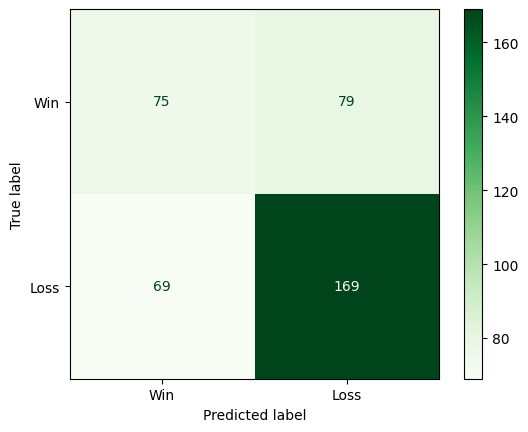

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cMatrix = confusion_matrix(testing_data_rolling['HOME_TEAM_WINS'], preds)

displayMatrix = ConfusionMatrixDisplay(confusion_matrix=cMatrix, display_labels=['Win', 'Loss'])
displayMatrix.plot(cmap='Greens')

As you can see, this model is fairly good at predicting the losses a team may have. Additionally, the model is only slightly reliable at detecting a victory correctly.

Let's look at the feature importances and visualize them.

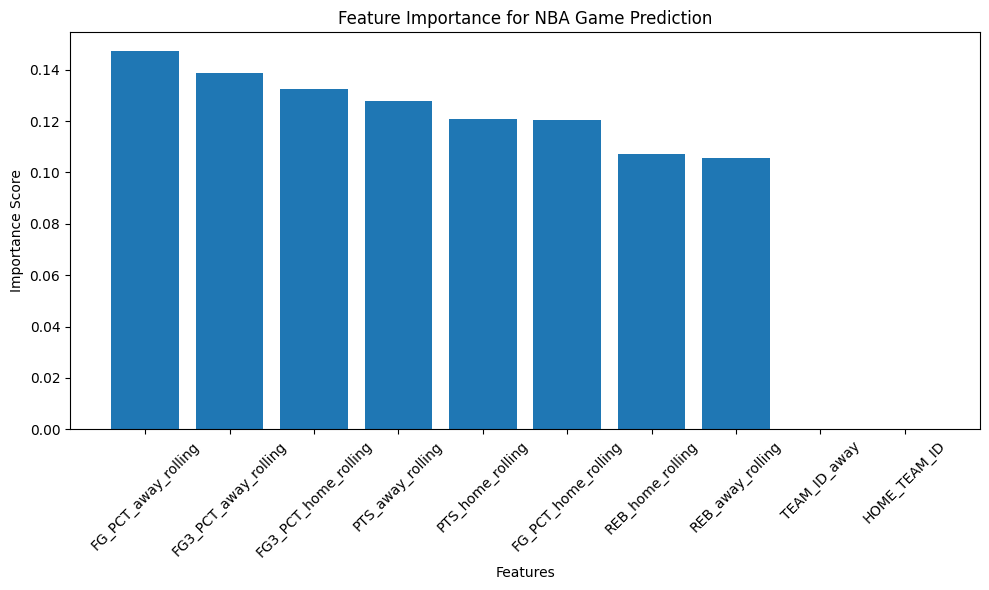

In [ ]:
import matplotlib.pyplot as plt

feature_importances = rf.feature_importances_

sorted_idx = feature_importances.argsort()[::-1]
feature_names_sorted = [predictors[i] for i in sorted_idx]
feature_importances_sorted = feature_importances[sorted_idx]

plt.figure(figsize=(10, 6))
plt.bar(feature_names_sorted, feature_importances_sorted)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Feature Importance for NBA Game Prediction")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

As one might expect, the team IDs for either the home or away team are relatively unimportant. Interestingly, the most important stats for determining win/loss are the away team's stats, rather than the home team's stats.

# **Generating Predictions from User Input**

To prep the prediction section, first request live data from nba_api to be used in prediction input

In [ ]:
queryRequest = "https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&Height=&ISTRound=&LastNGames=5&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2023-24&SeasonSegment=&SeasonType=Regular%20Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision="

In [ ]:
from nba_api.stats.endpoints import leaguedashteamstats

request = leaguedashteamstats.LeagueDashTeamStats(last_n_games=5, per_mode_detailed='PerGame')
foundStatistics = request.get_data_frames()[0]
foundStatistics.head()

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
0,1610612737,Atlanta Hawks,5,0,5,0.0,50.0,40.8,92.2,0.443,...,19,9,28,17,30,21,26,3,20,30
1,1610612738,Boston Celtics,5,3,2,0.6,48.0,46.2,91.8,0.503,...,15,5,2,4,2,13,2,30,10,6
2,1610612751,Brooklyn Nets,5,2,3,0.4,48.0,35.8,82.0,0.437,...,5,30,25,30,3,19,9,7,29,24
3,1610612766,Charlotte Hornets,5,2,3,0.4,48.0,40.4,83.6,0.483,...,30,16,20,14,9,1,9,15,21,26
4,1610612741,Chicago Bulls,5,2,3,0.4,49.0,46.6,91.6,0.509,...,12,23,6,5,16,7,22,16,9,16


Once statistics have been gathered, obtain user input to find team specific statistics.

In [ ]:
import ipywidgets as widgets
from ipywidgets import Button
from IPython.display import display

Generate a function to scrape data and then make a prediction using the trained machine learning model.

In [ ]:
def genPredictor():
  homeName = homeTeam.value
  awayName = awayTeam.value

  if homeName == awayName:
    print("Please select two distinct teams.")
    return 0

  try:
    selectedHomeRow = foundStatistics.loc[foundStatistics['TEAM_NAME'] == homeName]
    selectedAwayRow = foundStatistics.loc[foundStatistics['TEAM_NAME'] == awayName]

    homeID = selectedHomeRow['TEAM_ID'].values[0]
    homePoints = selectedHomeRow['PTS'].values[0]
    homeFGP = selectedHomeRow['FG_PCT'].values[0]
    homeREB = selectedHomeRow['REB'].values[0]
    homeFG3P = selectedHomeRow['FG3_PCT'].values[0]

    awayID = selectedAwayRow['TEAM_ID'].values[0]
    awayPoints = selectedAwayRow['PTS'].values[0]
    awayFGP = selectedAwayRow['FG_PCT'].values[0]
    awayREB = selectedAwayRow['REB'].values[0]
    awayFG3P = selectedAwayRow['FG3_PCT'].values[0]

    inputData = {
        'HOME_TEAM_ID': [homeID],
        'PTS_home_rolling': [homePoints],
        'FG_PCT_home_rolling': [homeFGP],
        'REB_home_rolling': [homeREB],
        'FG3_PCT_home_rolling': [homeFG3P],

        'TEAM_ID_away': [awayID],
        'PTS_away_rolling': [awayPoints],
        'FG_PCT_away_rolling': [awayFGP],
        'REB_away_rolling': [awayREB],
        'FG3_PCT_away_rolling': [awayFG3P]
    }

    inputDataFrame = pd.DataFrame(inputData)
    prediction = rf.predict(inputDataFrame[predictors])
    return prediction
  except KeyError:
    print("Error finding teams.")


In [ ]:
options = ["Atlanta Hawks", "Boston Celtics", "New Orleans Pelicans", "Chicago Bulls", "Dallas Mavericks", "Denver Nuggets", "Houston Rockets", "Los Angeles Clippers", "Los Angeles Lakers", "Miami Heat", "Milwaukee Bucks", "Minnesota Timberwolves", "Brooklyn Nets", "New York Knicks", "Orlando Magic", "Indiana Pacers", "Philadelphia 76ers", "Phoenix Suns", "Portland Trail Blazers", "Sacramento Kings", "San Antonio Spurs", "Oklahoma City Thunder", "Toronto Raptors", "Utah Jazz", "Memphis Grizzlies", "Washington Wizards", "Detroit Pistons", "Charlotte Hornets", "Cleveland Cavaliers", "Golden State Warriors"]
homeTeam = widgets.Dropdown(
    options=options,
    description="Home team: "
)

awayTeam = widgets.Dropdown(
    options=options,
    description="Away team: "
)

def on_button_click(button):
  outcome = genPredictor()
  if outcome == 1:
    print("The " + homeTeam.value + " wins!")
  elif outcome == 0:
    print("The " + awayTeam.value + " wins!")

test = Button(description = "Predict the winner!")
test.on_click(on_button_click)

# **Interactive section - calculate the average for any selected team!**

Select the teams you want to simulate an outcome for and then predict the outcome!

In [ ]:
display(homeTeam)
display(awayTeam)
display(test)

Dropdown(description='Home team: ', options=('Atlanta Hawks', 'Boston Celtics', 'New Orleans Pelicans', 'Chica…

Dropdown(description='Away team: ', options=('Atlanta Hawks', 'Boston Celtics', 'New Orleans Pelicans', 'Chica…

Button(description='Predict the winner!', style=ButtonStyle())